Licensed under the MIT License.

Copyright (c) 2021-2031. All rights reserved.

# All Real Forecast

* Forecast with all real labels
* Get feature importance

In [16]:
import pandas as pd
import timeit
import lightgbm as lgb
from lightgbm import LGBMClassifier
import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
raw_df = pd.read_pickle('../../crystal_ball/data_collector/structured_data/deposit.pkl')
print(raw_df.shape)
print(raw_df['deposit'].value_counts())

raw_df.head()

(11162, 17)
0    5873
1    5289
Name: deposit, dtype: int64


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,1
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,1
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,1
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,1
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,1


In [3]:
# convert categorical features to "category"
cat_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
raw_df[cat_features] = raw_df[cat_features].astype('category')
raw_df.dtypes

age             int64
job          category
marital      category
education    category
default      category
balance         int64
housing      category
loan         category
contact      category
day             int64
month        category
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome     category
deposit         int32
dtype: object

In [4]:
label_col = 'deposit'
y = raw_df[label_col]
X = raw_df.drop(label_col, axis=1)
print(X.shape, y.shape)
print()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10, stratify=y)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(y_train.value_counts()*100/y_train.shape)
print(y_test.value_counts()*100/y_test.shape)
print()

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)


opt_X_train, opt_X_val, opt_y_train, opt_y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=10, stratify=y_train)
print(opt_X_train.shape, opt_y_train.shape, opt_X_val.shape, opt_y_val.shape)
print(opt_y_train.value_counts()*100/opt_y_train.shape)
print(opt_y_val.value_counts()*100/opt_y_val.shape)

opt_X_train.reset_index(inplace=True, drop=True)
opt_X_val.reset_index(inplace=True, drop=True)
opt_y_train.reset_index(inplace=True, drop=True)
opt_y_val.reset_index(inplace=True, drop=True)

(11162, 16) (11162,)

(8371, 16) (8371,) (2791, 16) (2791,)
0    52.610202
1    47.389798
Name: deposit, dtype: float64
0    52.633465
1    47.366535
Name: deposit, dtype: float64

(6696, 16) (6696,) (1675, 16) (1675,)
0    52.613501
1    47.386499
Name: deposit, dtype: float64
0    52.597015
1    47.402985
Name: deposit, dtype: float64


In [5]:
def get_hpo_params(opt_X_train, opt_X_val, opt_y_train, opt_y_val, n_trials=180, cat_features=""):
    """
    To make below optuna output reproducible, need to set hashseed in your OS: 
    https://gerrychain.readthedocs.io/en/latest/topics/reproducibility.html#set-pythonhashseed-0
    This is ot make pruning behaviour replicable.
    """
    
    def objective(trial):
        dtrain = lgb.Dataset(opt_X_train, opt_y_train, categorical_feature=cat_features)
        dval = lgb.Dataset(opt_X_val, opt_y_val, categorical_feature=cat_features)
        upper = min(32768, int(opt_X_train.shape[0]))

        params = {
            "objective": "binary",
            "metric": "auc",
            "random_state": 10,
            "verbosity": -1,
            "boosting": "gbdt",
            "num_threads": 4,

            "num_leaves": trial.suggest_int("num_leaves", 4, 30),
            "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 1.0),
            "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1.0),
            "feature_fraction": trial.suggest_uniform("feature_fraction", 0.1, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 10, 30),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1000, 3000),
            "num_iterations": trial.suggest_int("num_iterations", 1000, 3000)
        }

        pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "auc")
        clf = lgb.train(
            params, dtrain, valid_sets=[dval], verbose_eval=False, callbacks=[pruning_callback]
        )

        y_val_pred = clf.predict(opt_X_val)
        auc = roc_auc_score(opt_y_val, y_val_pred)
        return auc


    start = timeit.default_timer()
    study = optuna.create_study(direction="maximize", pruner=optuna.pruners.HyperbandPruner(),
                               sampler=optuna.samplers.TPESampler(seed=10), study_name='lgbm_hpo')
    study.optimize(objective, n_trials=n_trials)

    print("Number of finished trials: {}".format(len(study.trials)))
    best_trial = study.best_trial
    print(f"Best trial performance: {best_trial.value}")
    stop = timeit.default_timer()
    print('Time (min): ', (stop - start)/60)
    
    return best_trial.params

In [11]:
best_params = get_hpo_params(opt_X_train, opt_X_val, opt_y_train, opt_y_val, n_trials=180, cat_features=cat_features)

[I 2022-11-29 22:58:21,026] A new study created in memory with name: lgbm_hpo
C:\Users\wuhan\AppData\Local\Temp\ipykernel_4560\3449496262.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 1.0),
C:\Users\wuhan\AppData\Local\Temp\ipykernel_4560\3449496262.py:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1.0),
C:\Users\wuhan\AppData\Local\Temp\ipykernel_4560\3449496262.py:24: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/

Number of finished trials: 180
Best trial performance: 0.9113012748851345
Time (min):  2.141429714999996


In [13]:
print(best_params)

constant_params = {'objective': 'binary', 'metric': 'auc', 'random_state': 10, 'verbosity': -1, 'boosting': 'gbdt', 'num_threads': 4}
best_params.update(constant_params)
print(best_params)

{'num_leaves': 4, 'learning_rate': 0.17937097905882862, 'bagging_fraction': 0.8506740422636537, 'feature_fraction': 0.6643670461510903, 'bagging_freq': 18, 'min_data_in_leaf': 1133, 'num_iterations': 2956}
{'num_leaves': 4, 'learning_rate': 0.17937097905882862, 'bagging_fraction': 0.8506740422636537, 'feature_fraction': 0.6643670461510903, 'bagging_freq': 18, 'min_data_in_leaf': 1133, 'num_iterations': 2956, 'objective': 'binary', 'metric': 'auc', 'random_state': 10, 'verbosity': -1, 'boosting': 'gbdt', 'num_threads': 4}


In [17]:
opt_model = LGBMClassifier(**best_params)
opt_model.fit(X_train, y_train)
y_pred = opt_model.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
print(f'Testing AUC is {auc}')

Testing AUC is 0.8428958948887189


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

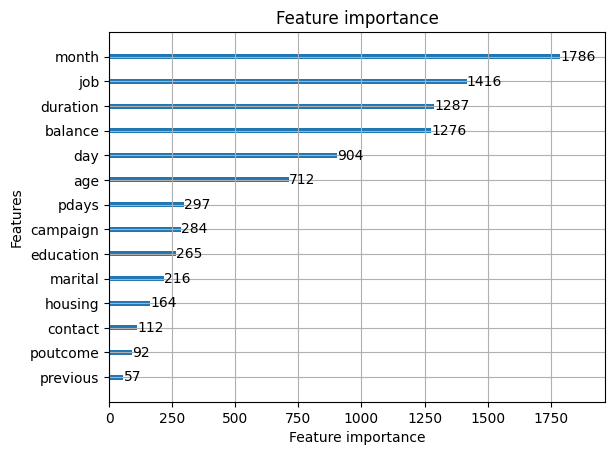

In [18]:
lgb.plot_importance(opt_model)